In [4]:
import carla
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import json
import statistics

In [5]:
def read_all_json_files_in_directory(directory_path):
    """
    Finds, reads, and parses all JSON files in a given directory.

    Args:
        directory_path (str): The path to the directory to search.

    Returns:
        list: A list containing the parsed data from each JSON file.
              Returns an empty list if no files are found or an error occurs.
    """
    # 1. Create a search pattern to find all files ending with .json
    #    os.path.join is the recommended way to build file paths.
    search_pattern = os.path.join(directory_path, '*.json')

    # 2. Use glob.glob() to get a list of all file paths that match the pattern.
    json_file_paths = glob.glob(search_pattern)

    if not json_file_paths:
        print(f"Warning: No JSON files found in '{directory_path}'")
        return []

    print(f"Found {len(json_file_paths)} files to process.")

    all_data = []
    # 3. Loop through the list of file paths.
    for file_path in json_file_paths:
        # print(f"--> Reading '{os.path.basename(file_path)}'...")
        try:
            # 4. Open and read the file. The 'with' statement ensures the
            #    file is automatically closed, even if errors occur.
            with open(file_path, 'r') as f:
                # 5. Use json.load() to parse the JSON content into a Python dict.
                data = json.load(f)
                all_data.append(data)
                # print(f"    ...success. Loaded {len(data.get('frames', []))} data points.")

        except json.JSONDecodeError:
            print(f"    ...Error: Failed to decode JSON from '{file_path}'. File may be corrupt or empty.")
        except Exception as e:
            print(f"    ...An unexpected error occurred with file '{file_path}': {e}")

    return all_data



# Scenario 2 Driving Curved road

## Data preparation

In [6]:
# Specify the path to your parent directory
directory_path = '/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Curved_straight'

# This list will store the names of the subdirectories
directory_list = []

try:
    # Get a list of all entries in the directory
    all_entries = os.listdir(directory_path)
    
    # Loop through all the entries
    for entry in all_entries:
        # Create the full path to the entry
        full_path = os.path.join(directory_path, entry)
        
        # Check if the entry is a directory
        if os.path.isdir(full_path):
            # If it's a directory, add its name to our list
            directory_list.append(entry)
            
    # Print the final list of directories
    print("Subdirectories in the directory:")
    for dir_name in directory_list:
        print(dir_name)

except FileNotFoundError:
    print(f"Error: The directory '{directory_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")
Data_container = {}
for dir_name in directory_list:
    dir_path = os.path.join(directory_path, dir_name)
    Data_container[dir_name] = read_all_json_files_in_directory(dir_path)

for key, value in Data_container.items():
    for i in range(len(value)):
        for j in range(len(value[i]['distance'])):
            value[i]['distance'][j]=round(value[i]['distance'][j],1)


Data_container = sorted(Data_container.items())
Data_container = dict(Data_container)
print(Data_container.keys())

Subdirectories in the directory:
20ms_delay_no_LKA
no_delay_no_LKA
100ms_delay_LKA
no_delay_LKA
100ms_delay_no_LKA
20ms_delay_LKA
Found 1 files to process.
Found 1 files to process.
Found 1 files to process.
Found 1 files to process.
Found 1 files to process.
Found 1 files to process.
dict_keys(['100ms_delay_LKA', '100ms_delay_no_LKA', '20ms_delay_LKA', '20ms_delay_no_LKA', 'no_delay_LKA', 'no_delay_no_LKA'])


## Plot distance to lane center

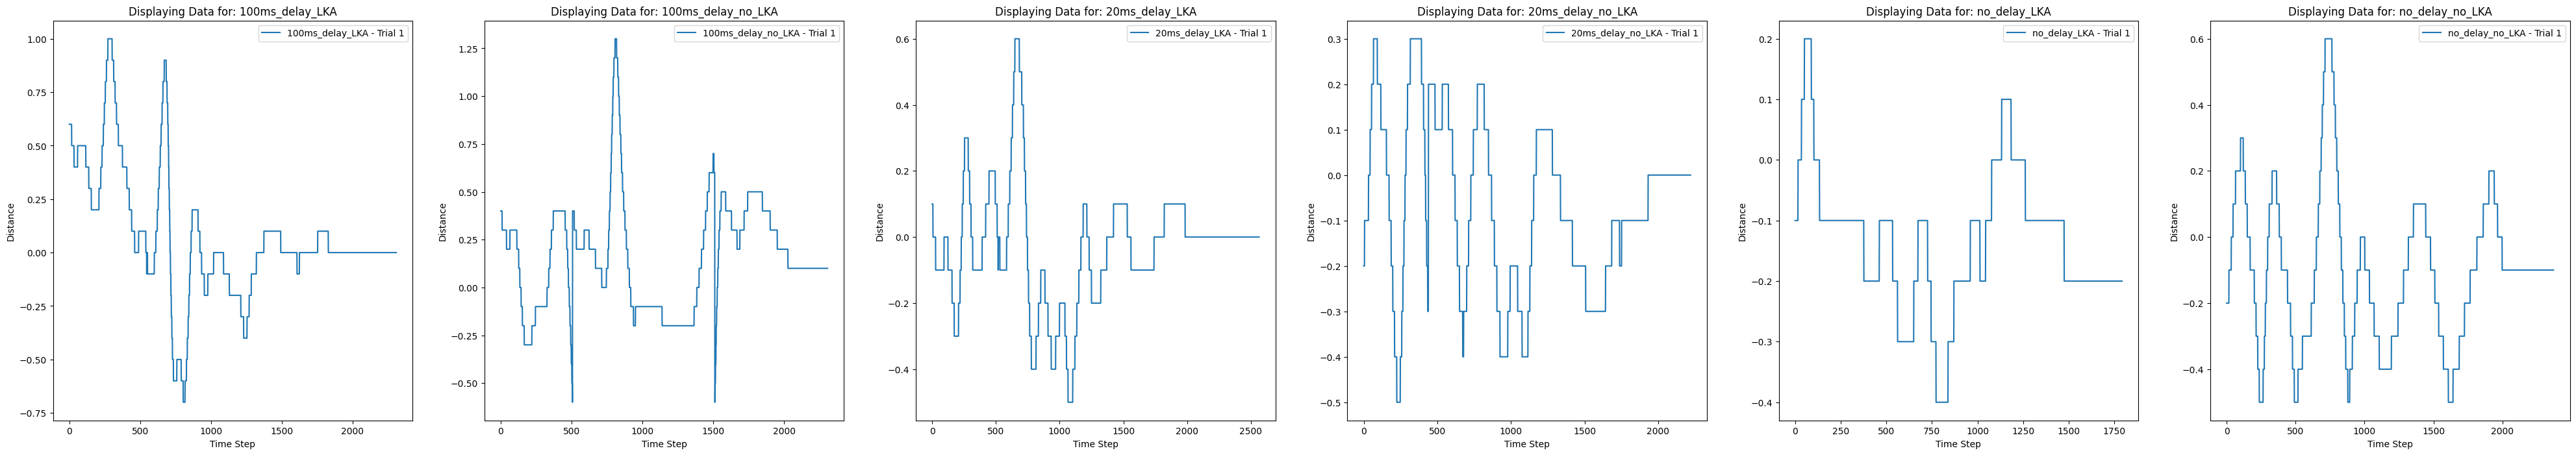

In [7]:


fig, axs = plt.subplots(1, len(directory_list), figsize=(50, 8))
# Get an ordered list of the keys from your data dictionary
# e.g., ['Key1', 'Key2', 'Key3', ...]
data_keys = list(Data_container.keys())

# Determine the number of figures to create, ensuring we don't go out of bounds
# This will be 8 if both lists have at least 8 items.
num_figures = min(len(directory_list), len(data_keys))

# Loop through each figure/axis index (from 0 to 7)
for i in range(num_figures):
    
    # --- Select the Data for the Current Figure ---
    # Get the specific key corresponding to the current figure (e.g., on first loop, key = 'Key1')
    key = data_keys[i]
    
    # Get the list of 6 data values associated with that key
    values = Data_container[key]
    
    # --- Plot the 6 Lines on the Current Figure ---
    # Now, loop through only those 6 values and plot them on the current axis (axs[i])
    for j in range(len(values)):
        
        # Your original logic for extracting the data to plot
        distance_data = values[j]['distance']
        start_index = distance_data.count(-0.2) # Skips the initial 25.7 values
        
        data_to_plot = distance_data[start_index:]
        x_values = range(len(data_to_plot))
        
        # Plot on the correct axis (axs[i]) with a clear label
        axs[i].plot(x_values, data_to_plot, label=f"{key} - Trial {j+1}")
        
    # --- Finalize the Current Figure ---
    # Set the title and legend for the current figure after all its lines are plotted
    axs[i].set_title(f"Displaying Data for: {key}")
    axs[i].set_xlabel("Time Step")
    axs[i].set_ylabel("Distance")
    axs[i].legend(loc='best') # Add a legend to show the labels


## Average and variance

In [8]:
table_data = []

# Loop through each scenario in the main data container
for key, values in Data_container.items():
    
    # This list will gather all valid absolute distance points from all 6 trials for the current key
    all_abs_distances_for_key = []
    # This list will store the length of each trial for averaging
    trial_lengths = []
    
    # Loop through each of the 6 trials associated with the current key
    for trial_data in values:
        
        # Get the distance list for the current trial
        distance_list = trial_data['distance']
        
        # Filter out the initial placeholder values
        start_index = distance_list.count(-0.2)
        valid_distances = distance_list[start_index:]
        
        # Store the length of this trial's valid data
        trial_lengths.append(len(valid_distances))
        
        # Apply absolute value to each valid distance point
        # A list comprehension is a concise way to do this
        abs_distances = [abs(d) for d in valid_distances]
        
        # Add these absolute distances to our aggregate list
        if abs_distances:
            all_abs_distances_for_key.extend(abs_distances)
            
    # --- Perform Calculations ---
    if all_abs_distances_for_key:
        average_distance = np.mean(all_abs_distances_for_key)
        std_dev_distance = np.std(all_abs_distances_for_key)
    else:
        # Handle cases with no valid data
        average_distance = float('nan')
        std_dev_distance = float('nan')

    # Calculate the average length of the trials for this scenario
    if trial_lengths:
        average_length = np.mean(trial_lengths)
    else:
        average_length = 0

    # --- Append the results for this key to our table data list ---
    table_data.append({
        'Scenario': key,
        'Average Distance (abs)': average_distance,
        'Std Deviation (abs)': std_dev_distance,
        'Average Length': average_length
    })

# --- Create and Display the Pandas DataFrame ---

# Create the DataFrame from our list of dictionaries
df = pd.DataFrame(table_data)

# Set the 'Scenario' column as the index of the table for a cleaner look
df.set_index('Scenario', inplace=True)

# Set display options to format floating point numbers nicely
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

print("--- Statistical Summary of Absolute Distance ---")
print(df)


--- Statistical Summary of Absolute Distance ---
                    Average Distance (abs)  Std Deviation (abs)  \
Scenario                                                          
100ms_delay_LKA                       0.19                 0.24   
100ms_delay_no_LKA                    0.26                 0.20   
20ms_delay_LKA                        0.12                 0.14   
20ms_delay_no_LKA                     0.16                 0.12   
no_delay_LKA                          0.15                 0.09   
no_delay_no_LKA                       0.20                 0.15   

                    Average Length  
Scenario                            
100ms_delay_LKA            2310.00  
100ms_delay_no_LKA         2308.00  
20ms_delay_LKA             2566.00  
20ms_delay_no_LKA          2221.00  
no_delay_LKA               1794.00  
no_delay_no_LKA            2371.00  


## Plot distance to lane center

In [9]:
# Specify the path to your parent directory
directory_path = '/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Follow Leading Vehicle data/Distance to lane center/'

# This list will store the names of the subdirectories
directory_list = []

try:
    # Get a list of all entries in the directory
    all_entries = os.listdir(directory_path)
    
    # Loop through all the entries
    for entry in all_entries:
        # Create the full path to the entry
        full_path = os.path.join(directory_path, entry)
        
        # Check if the entry is a directory
        if os.path.isdir(full_path):
            # If it's a directory, add its name to our list
            directory_list.append(entry)
            
    # Print the final list of directories
    print("Subdirectories in the directory:")
    for dir_name in directory_list:
        print(dir_name)

except FileNotFoundError:
    print(f"Error: The directory '{directory_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")
Data_container = {}
for dir_name in directory_list:
    dir_path = os.path.join(directory_path, dir_name)
    Data_container[dir_name] = read_all_json_files_in_directory(dir_path)

for key, value in Data_container.items():
    for i in range(len(value)):
        for j in range(len(value[i]['distance'])):
            value[i]['distance'][j]=round(value[i]['distance'][j],1)


Data_container = sorted(Data_container.items())
Data_container = dict(Data_container)
print(Data_container.keys())

Subdirectories in the directory:
no_LKA_no_delay
no_LKA_35ms_delay
no_LKA_100ms_delay
no_LKA_20ms_delay
LKA_20ms_delay
LKA_35ms_delay
LKA_100ms_delay
LKA_no_delay
Found 6 files to process.
Found 6 files to process.
Found 6 files to process.
Found 6 files to process.
Found 6 files to process.
Found 6 files to process.
Found 6 files to process.
Found 6 files to process.
dict_keys(['LKA_100ms_delay', 'LKA_20ms_delay', 'LKA_35ms_delay', 'LKA_no_delay', 'no_LKA_100ms_delay', 'no_LKA_20ms_delay', 'no_LKA_35ms_delay', 'no_LKA_no_delay'])


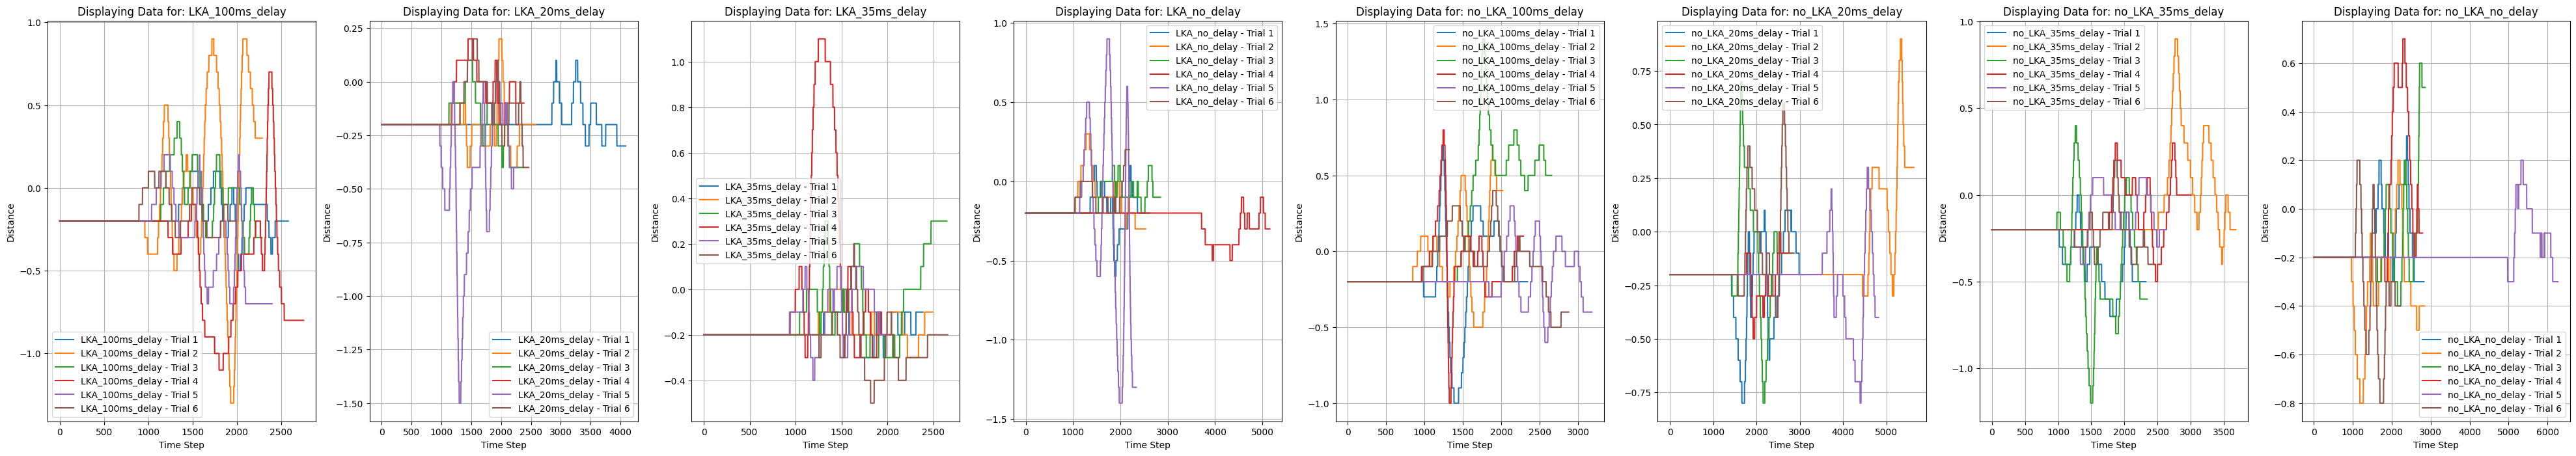

In [10]:


fig, axs = plt.subplots(1, len(directory_list), figsize=(50, 8))
# Get an ordered list of the keys from your data dictionary
# e.g., ['Key1', 'Key2', 'Key3', ...]
data_keys = list(Data_container.keys())

# Determine the number of figures to create, ensuring we don't go out of bounds
# This will be 8 if both lists have at least 8 items.
num_figures = min(len(directory_list), len(data_keys))

# Loop through each figure/axis index (from 0 to 7)
for i in range(num_figures):
    
    # --- Select the Data for the Current Figure ---
    # Get the specific key corresponding to the current figure (e.g., on first loop, key = 'Key1')
    key = data_keys[i]
    
    # Get the list of 6 data values associated with that key
    values = Data_container[key]
    
    # --- Plot the 6 Lines on the Current Figure ---
    # Now, loop through only those 6 values and plot them on the current axis (axs[i])
    for j in range(len(values)):
        
        # Your original logic for extracting the data to plot
        distance_data = values[j]['distance']
        start_index = distance_data.count(25.7) # Skips the initial 25.7 values
        
        data_to_plot = distance_data[start_index:]
        x_values = range(len(data_to_plot))
        
        # Plot on the correct axis (axs[i]) with a clear label
        axs[i].plot(x_values, data_to_plot, label=f"{key} - Trial {j+1}")
        
    # --- Finalize the Current Figure ---
    # Set the title and legend for the current figure after all its lines are plotted
    axs[i].set_title(f"Displaying Data for: {key}")
    axs[i].set_xlabel("Time Step")
    axs[i].set_ylabel("Distance")
    axs[i].legend(loc='best') # Add a legend to show the labels
    axs[i].grid(True)


In [11]:
import numpy as np
import pandas as pd


# This list will store the data for our final table (as a list of dictionaries)
table_data = []

# Loop through each scenario in the main data container
for key, values in Data_container.items():
    
    # This list will gather all valid absolute distance points from all 6 trials for the current key
    all_abs_distances_for_key = []
    
    # Loop through each of the 6 trials associated with the current key
    for trial_data in values:
        
        # Get the distance list for the current trial
        distance_list = trial_data['distance']
        
        # Filter out the initial placeholder values
        start_index = distance_list.count(-0.3)
        valid_distances = distance_list[start_index:]
        
        # Apply absolute value to each valid distance point
        # A list comprehension is a concise way to do this
        abs_distances = [abs(d) for d in valid_distances]
        
        # Add these absolute distances to our aggregate list
        if abs_distances:
            all_abs_distances_for_key.extend(abs_distances)
            
    # --- Perform Calculations ---
    if all_abs_distances_for_key:
        average_distance = np.mean(all_abs_distances_for_key)
        std_dev_distance = np.std(all_abs_distances_for_key)
    else:
        # Handle cases with no valid data
        average_distance = float('nan')
        std_dev_distance = float('nan')

    # --- Append the results for this key to our table data list ---
    table_data.append({
        'Scenario': key,
        'Average Distance (abs)': average_distance,
        'Std Deviation (abs)': std_dev_distance
    })

# --- Create and Display the Pandas DataFrame ---

# Create the DataFrame from our list of dictionaries
df = pd.DataFrame(table_data)

# Set the 'Scenario' column as the index of the table for a cleaner look
df.set_index('Scenario', inplace=True)

# Set display options to format floating point numbers nicely
pd.set_option('display.float_format', lambda x: f'{x:.4f}')

print("--- Statistical Summary of Absolute Distance ---")
print(df)

--- Statistical Summary of Absolute Distance ---
                    Average Distance (abs)  Std Deviation (abs)
Scenario                                                       
LKA_100ms_delay                     0.2722               0.2222
LKA_20ms_delay                      0.2072               0.1457
LKA_35ms_delay                      0.1994               0.1393
LKA_no_delay                        0.2183               0.1763
no_LKA_100ms_delay                  0.2434               0.1896
no_LKA_20ms_delay                   0.2229               0.1253
no_LKA_35ms_delay                   0.2381               0.1599
no_LKA_no_delay                     0.2289               0.1301


# Scenario 1 Urban driving 60kmh

## Data preparation

In [12]:
import os

# Specify the path to your parent directory
directory_path = '/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Free ride data'

# This list will store the names of the subdirectories
directory_list = []

try:
    # Get a list of all entries in the directory
    all_entries = os.listdir(directory_path)
    
    # Loop through all the entries
    for entry in all_entries:
        # Create the full path to the entry
        full_path = os.path.join(directory_path, entry)
        
        # Check if the entry is a directory
        if os.path.isdir(full_path):
            # If it's a directory, add its name to our list
            directory_list.append(entry)
            
    # Print the final list of directories
    print("Subdirectories in the directory:")
    for dir_name in directory_list:
        print(dir_name)

except FileNotFoundError:
    print(f"Error: The directory '{directory_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Data_container = {}
for dir_name in directory_list:
    dir_path = os.path.join(directory_path, dir_name)
    Data_container[dir_name] = read_all_json_files_in_directory(dir_path)

for key, value in Data_container.items():
    for i in range(len(value)):
        for j in range(len(value[i]['distance'])):
            value[i]['distance'][j]=round(value[i]['distance'][j],1)

Data_container = sorted(Data_container.items())
Data_container_average = dict(Data_container)
print(Data_container_average.keys())

Subdirectories in the directory:
35ms_delay_LKA
20ms_delay_no_LKA
no_delay_no_LKA
100ms_delay_LKA
no_delay_LKA
100ms_delay_no_LKA
35ms_delay_no_LKA
20ms_delay_LKA
Found 6 files to process.
Found 6 files to process.
Found 6 files to process.
Found 6 files to process.
Found 6 files to process.
Found 6 files to process.
Found 6 files to process.
Found 6 files to process.
dict_keys(['100ms_delay_LKA', '100ms_delay_no_LKA', '20ms_delay_LKA', '20ms_delay_no_LKA', '35ms_delay_LKA', '35ms_delay_no_LKA', 'no_delay_LKA', 'no_delay_no_LKA'])


## plot distance to lane center

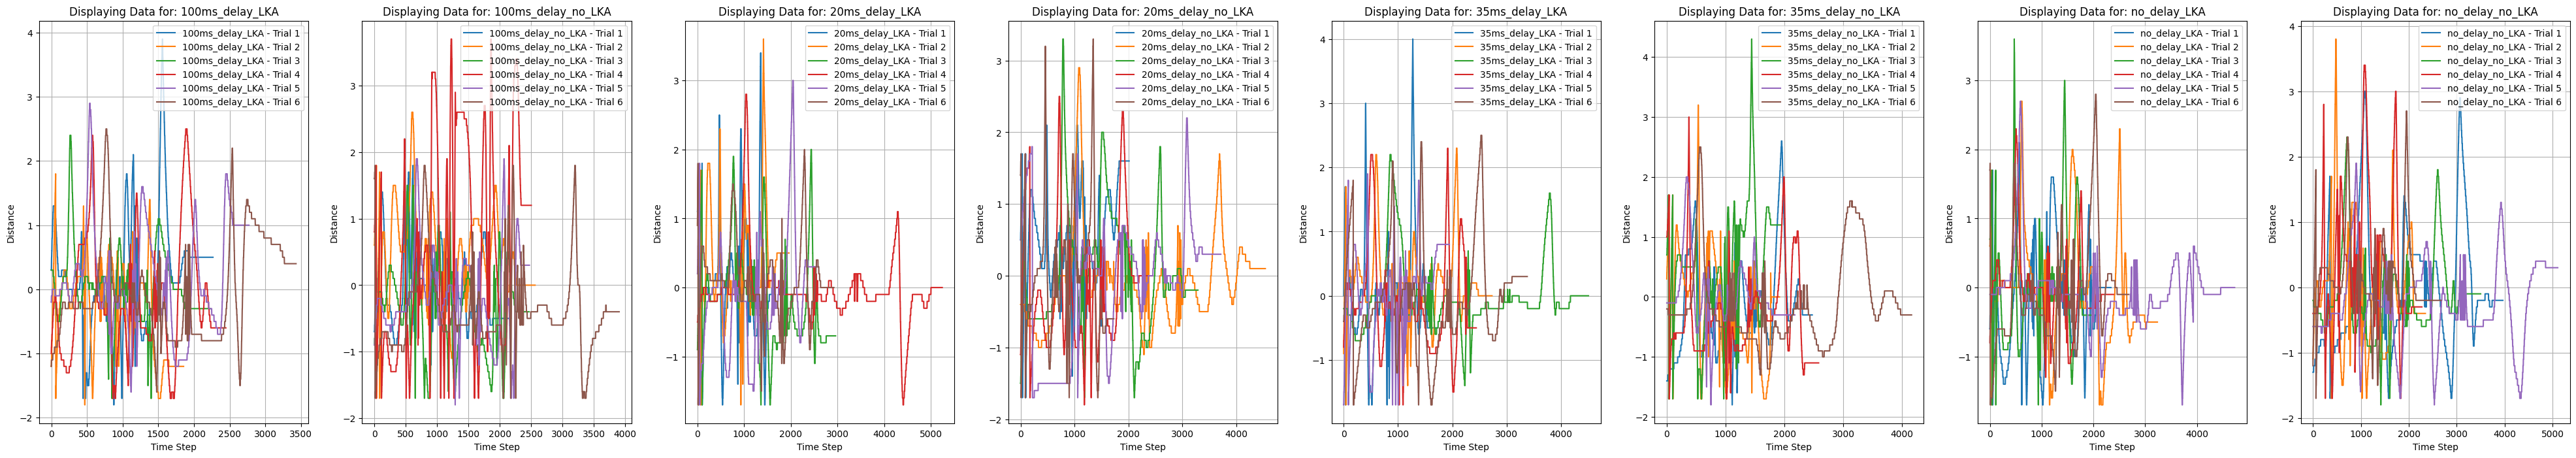

In [13]:


fig, axs = plt.subplots(1, len(directory_list), figsize=(50, 8))
# Get an ordered list of the keys from your data dictionary
# e.g., ['Key1', 'Key2', 'Key3', ...]
data_keys = list(Data_container_average.keys())

# Determine the number of figures to create, ensuring we don't go out of bounds
# This will be 8 if both lists have at least 8 items.
num_figures = min(len(directory_list), len(data_keys))

# Loop through each figure/axis index (from 0 to 7)
for i in range(num_figures):
    
    # --- Select the Data for the Current Figure ---
    # Get the specific key corresponding to the current figure (e.g., on first loop, key = 'Key1')
    key = data_keys[i]
    
    # Get the list of 6 data values associated with that key
    values = Data_container_average[key]
    
    # --- Plot the 6 Lines on the Current Figure ---
    # Now, loop through only those 6 values and plot them on the current axis (axs[i])
    for j in range(len(values)):
        
        # Your original logic for extracting the data to plot
        distance_data = values[j]['distance']
        start_index = distance_data.count(-0.3) # Skips the initial 25.7 values
        
        data_to_plot = distance_data[start_index:]
        x_values = range(len(data_to_plot))
        
        # Plot on the correct axis (axs[i]) with a clear label
        axs[i].plot(x_values, data_to_plot, label=f"{key} - Trial {j+1}")
        
    # --- Finalize the Current Figure ---
    # Set the title and legend for the current figure after all its lines are plotted
    axs[i].set_title(f"Displaying Data for: {key}")
    axs[i].set_xlabel("Time Step")
    axs[i].set_ylabel("Distance")
    axs[i].legend(loc='best') # Add a legend to show the labels
    axs[i].grid(True)


## Average and standard Dev

In [14]:
table_data = []

# Loop through each scenario in the main data container
for key, values in Data_container_average.items():
    
    # This list will gather all valid absolute distance points from all 6 trials for the current key
    all_abs_distances_for_key = []
    # This list will store the length of each trial for averaging
    trial_lengths = []
    
    # Loop through each of the 6 trials associated with the current key
    for trial_data in values:
        
        # Get the distance list for the current trial
        distance_list = trial_data['distance']
        
        # Filter out the initial placeholder values
        start_index = distance_list.count(-0.3)
        valid_distances = distance_list[start_index:]
        
        # Store the length of this trial's valid data
        trial_lengths.append(len(valid_distances))
        
        # Apply absolute value to each valid distance point
        # A list comprehension is a concise way to do this
        abs_distances = [abs(d) for d in valid_distances]
        
        # Add these absolute distances to our aggregate list
        if abs_distances:
            all_abs_distances_for_key.extend(abs_distances)
            
    # --- Perform Calculations ---
    if all_abs_distances_for_key:
        average_distance = np.mean(all_abs_distances_for_key)
        std_dev_distance = np.std(all_abs_distances_for_key)
    else:
        # Handle cases with no valid data
        average_distance = float('nan')
        std_dev_distance = float('nan')

    # Calculate the average length of the trials for this scenario
    if trial_lengths:
        average_length = np.mean(trial_lengths)
    else:
        average_length = 0

    # --- Append the results for this key to our table data list ---
    table_data.append({
        'Scenario': key,
        'Average Distance (m)': average_distance,
        'Std Deviation': std_dev_distance,
        'Average frame taken(frames)': average_length
    })

# --- Create and Display the Pandas DataFrame ---

# Create the DataFrame from our list of dictionaries
average_df = pd.DataFrame(table_data)

# Set the 'Scenario' column as the index of the table for a cleaner look
average_df.set_index('Scenario', inplace=True)

# Set display options to format floating point numbers nicely
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

print("--- Statistical Summary of Absolute Distance ---")
print(average_df)


--- Statistical Summary of Absolute Distance ---
                    Average Distance (m)  Std Deviation  \
Scenario                                                  
100ms_delay_LKA                     0.60           0.53   
100ms_delay_no_LKA                  0.68           0.60   
20ms_delay_LKA                      0.43           0.51   
20ms_delay_no_LKA                   0.60           0.55   
35ms_delay_LKA                      0.47           0.51   
35ms_delay_no_LKA                   0.63           0.52   
no_delay_LKA                        0.47           0.51   
no_delay_no_LKA                     0.59           0.56   

                    Average frame taken(frames)  
Scenario                                         
100ms_delay_LKA                         2499.67  
100ms_delay_no_LKA                      2681.67  
20ms_delay_LKA                          2907.67  
20ms_delay_no_LKA                       2953.17  
35ms_delay_LKA                          2788.50  
35ms_delay

## Lane crossing count

### Lane crossing data preparation

In [15]:

import os

# Specify the path to your parent directory
directory_path = '/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Free ride lane cross data'

# This list will store the names of the subdirectories
directory_list = []

try:
    # Get a list of all entries in the directory
    all_entries = os.listdir(directory_path)
    
    # Loop through all the entries
    for entry in all_entries:
        # Create the full path to the entry
        full_path = os.path.join(directory_path, entry)
        
        # Check if the entry is a directory
        if os.path.isdir(full_path):
            # If it's a directory, add its name to our list
            directory_list.append(entry)
            
    # Print the final list of directories
    print("Subdirectories in the directory:")
    for dir_name in directory_list:
        print(dir_name)

except FileNotFoundError:
    print(f"Error: The directory '{directory_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Data_container = {}
for dir_name in directory_list:
    dir_path = os.path.join(directory_path, dir_name)
    Data_container[dir_name] = read_all_json_files_in_directory(dir_path)

Data_container = sorted(Data_container.items())
Data_container = dict(Data_container)
print(Data_container.keys())

Subdirectories in the directory:
35ms_delay_LKA
20ms_delay_no_LKA
no_delay_no_LKA
100ms_delay_LKA
no_delay_LKA
100ms_delay_no_LKA
35ms_delay_no_LKA
20ms_delay_LKA
Found 6 files to process.
Found 6 files to process.
Found 6 files to process.
Found 6 files to process.
Found 6 files to process.
Found 6 files to process.
Found 6 files to process.
Found 6 files to process.
dict_keys(['100ms_delay_LKA', '100ms_delay_no_LKA', '20ms_delay_LKA', '20ms_delay_no_LKA', '35ms_delay_LKA', '35ms_delay_no_LKA', 'no_delay_LKA', 'no_delay_no_LKA'])


### Lane crossing dataframe

In [16]:
# This list will store the calculated averages for each scenario
table_data = []

# Loop through each scenario in the main data container
for scenario_key, trials in Data_container.items():
    
    # Lists to store the counts from each trial for later averaging
    broken_counts = []
    none_counts = []
    solid_counts = []
    Broken_solid_counts = []
    total_counts = []
    
    # Loop through each trial for the current scenario
    for trial in trials:
        crossings = trial['crossings_by_type']
        
        # Append the counts for each type to their respective lists.
        # Use .get(key, 0) to safely handle cases where a key might be missing.
        broken_counts.append(crossings.get('Broken', 0))
        solid_counts.append(crossings.get('Solid', 0))
        Broken_solid_counts.append(crossings.get('Broken', 0) + crossings.get('Solid', 0))
        none_counts.append(crossings.get('NONE', 0))
        total_counts.append(trial.get('total_crossings', 0))

    # --- Calculate Averages ---
    # np.mean calculates the average of the numbers in the list.
    # The result is NaN (Not a Number) if the list is empty, which is handled well by pandas.
    avg_broken = np.mean(broken_counts)
    avg_solid = np.mean(solid_counts)
    avg_broken_solid = np.mean(Broken_solid_counts)
    avg_none = np.mean(none_counts)
    avg_total = np.mean(total_counts)

    # --- Append the results for this scenario to our table data list ---
    table_data.append({
        'Scenario': scenario_key,
        'Avg Broken': avg_broken,        
        'Avg Solid': avg_solid,
        'Avg Broken + Solid': avg_broken_solid,
        'Avg NONE': avg_none,
        'Avg Total Crossings': avg_total
    })

# --- Create and Display the Pandas DataFrame ---

# Create the DataFrame from our list of dictionaries
lane_cross_df = pd.DataFrame(table_data)

# Set the 'Scenario' column as the index for a cleaner look
lane_cross_df.set_index('Scenario', inplace=True)

# Set display options to format floating point numbers nicely
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

print("--- Average Lane Crossings per Scenario ---")
print(lane_cross_df)

--- Average Lane Crossings per Scenario ---
                    Avg Broken  Avg Solid  Avg Broken + Solid  Avg NONE  \
Scenario                                                                  
100ms_delay_LKA           3.50       9.00               12.50     28.50   
100ms_delay_no_LKA        4.00      10.83               14.83     28.17   
20ms_delay_LKA            3.00       8.67               11.67     27.50   
20ms_delay_no_LKA         3.33       8.50               11.83     27.00   
35ms_delay_LKA            3.33       8.83               12.17     26.17   
35ms_delay_no_LKA         3.17       8.67               11.83     27.00   
no_delay_LKA              3.33       9.17               12.50     26.83   
no_delay_no_LKA           4.00       8.50               12.50     25.50   

                    Avg Total Crossings  
Scenario                                 
100ms_delay_LKA                   41.00  
100ms_delay_no_LKA                43.00  
20ms_delay_LKA                    39.

## Summary Table

In [17]:
summary_df=pd.concat([average_df, lane_cross_df], axis=1)

print(summary_df.loc[['100ms_delay_LKA','100ms_delay_no_LKA','20ms_delay_LKA','20ms_delay_no_LKA','no_delay_LKA','no_delay_no_LKA']])

                    Average Distance (m)  Std Deviation  \
Scenario                                                  
100ms_delay_LKA                     0.60           0.53   
100ms_delay_no_LKA                  0.68           0.60   
20ms_delay_LKA                      0.43           0.51   
20ms_delay_no_LKA                   0.60           0.55   
no_delay_LKA                        0.47           0.51   
no_delay_no_LKA                     0.59           0.56   

                    Average frame taken(frames)  Avg Broken  Avg Solid  \
Scenario                                                                 
100ms_delay_LKA                         2499.67        3.50       9.00   
100ms_delay_no_LKA                      2681.67        4.00      10.83   
20ms_delay_LKA                          2907.67        3.00       8.67   
20ms_delay_no_LKA                       2953.17        3.33       8.50   
no_delay_LKA                            2897.67        3.33       9.17   
no_delay_

# Scenario 1 Urban driving 30kmh

## Data preparation

In [18]:
# Specify the path to your parent directory
directory_path = '/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Free ride data (30kmh)'

# This list will store the names of the subdirectories
directory_list = []

try:
    # Get a list of all entries in the directory
    all_entries = os.listdir(directory_path)
    
    # Loop through all the entries
    for entry in all_entries:
        # Create the full path to the entry
        full_path = os.path.join(directory_path, entry)
        
        # Check if the entry is a directory
        if os.path.isdir(full_path):
            # If it's a directory, add its name to our list
            directory_list.append(entry)
            
    # Print the final list of directories
    print("Subdirectories in the directory:")
    for dir_name in directory_list:
        print(dir_name)

except FileNotFoundError:
    print(f"Error: The directory '{directory_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Data_container = {}
for dir_name in directory_list:
    dir_path = os.path.join(directory_path, dir_name)
    Data_container[dir_name] = read_all_json_files_in_directory(dir_path)

for key, value in Data_container.items():
    for i in range(len(value)):
        for j in range(len(value[i]['distance'])):
            value[i]['distance'][j]=round(value[i]['distance'][j],1)

Data_container = sorted(Data_container.items())
Data_container_average = dict(Data_container)
print(Data_container_average.keys())

Subdirectories in the directory:
20ms_delay_no_LKA
no_delay_no_LKA
100ms_delay_LKA
no_delay_LKA
100ms_delay_no_LKA
20ms_delay_LKA
Found 4 files to process.
Found 4 files to process.
Found 4 files to process.
Found 4 files to process.
Found 4 files to process.
Found 4 files to process.
dict_keys(['100ms_delay_LKA', '100ms_delay_no_LKA', '20ms_delay_LKA', '20ms_delay_no_LKA', 'no_delay_LKA', 'no_delay_no_LKA'])


## Plot distance to lane center

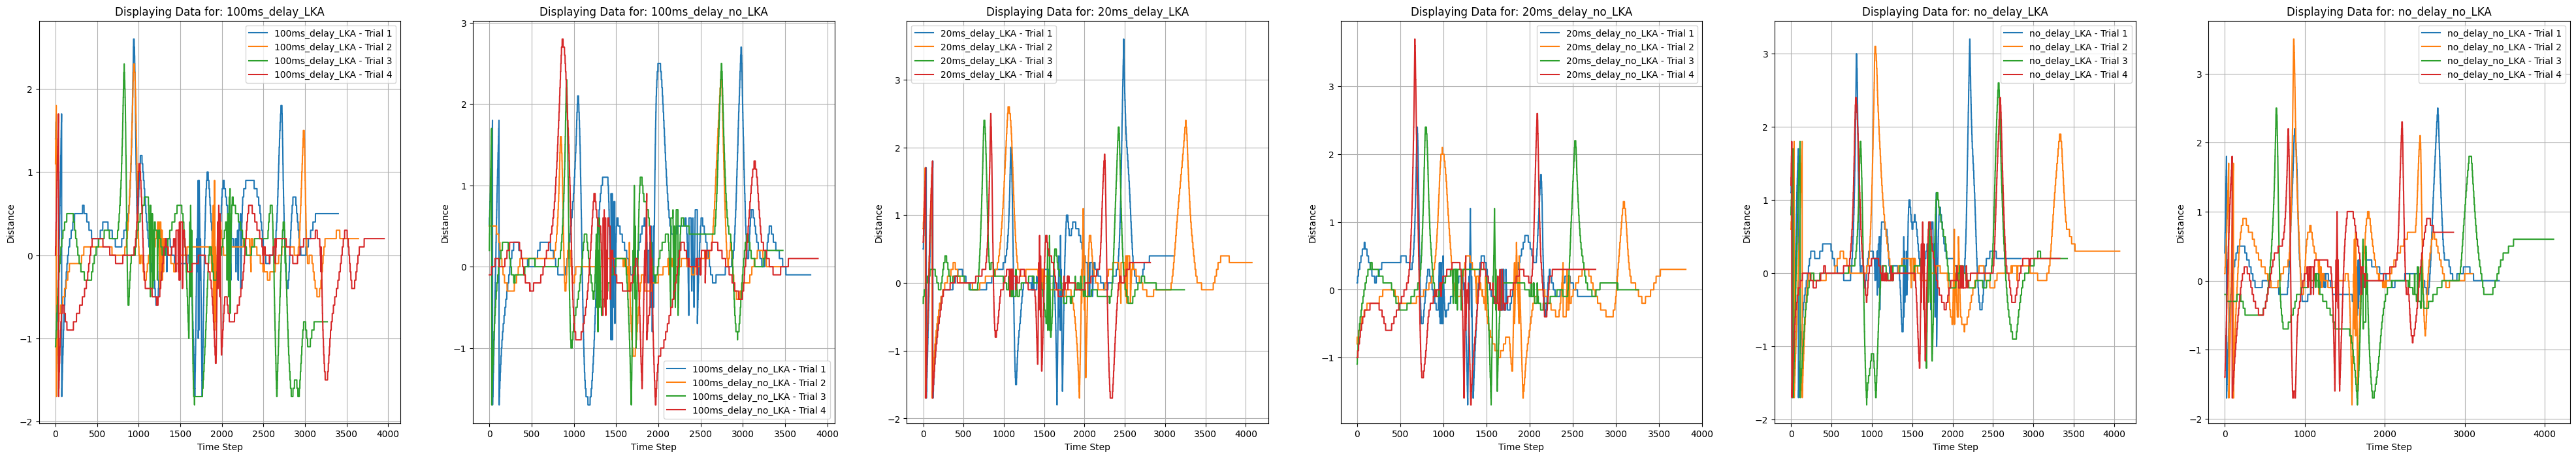

In [19]:


fig, axs = plt.subplots(1, len(directory_list), figsize=(50, 8))
# Get an ordered list of the keys from your data dictionary
# e.g., ['Key1', 'Key2', 'Key3', ...]
data_keys = list(Data_container_average.keys())

# Determine the number of figures to create, ensuring we don't go out of bounds
# This will be 8 if both lists have at least 8 items.
num_figures = min(len(directory_list), len(data_keys))

# Loop through each figure/axis index (from 0 to 7)
for i in range(num_figures):
    
    # --- Select the Data for the Current Figure ---
    # Get the specific key corresponding to the current figure (e.g., on first loop, key = 'Key1')
    key = data_keys[i]
    
    # Get the list of 6 data values associated with that key
    values = Data_container_average[key]
    
    # --- Plot the 6 Lines on the Current Figure ---
    # Now, loop through only those 6 values and plot them on the current axis (axs[i])
    for j in range(len(values)):
        
        # Your original logic for extracting the data to plot
        distance_data = values[j]['distance']
        start_index = distance_data.count(-0.3) # Skips the initial 25.7 values
        
        data_to_plot = distance_data[start_index:]
        x_values = range(len(data_to_plot))
        
        # Plot on the correct axis (axs[i]) with a clear label
        axs[i].plot(x_values, data_to_plot, label=f"{key} - Trial {j+1}")
        
    # --- Finalize the Current Figure ---
    # Set the title and legend for the current figure after all its lines are plotted
    axs[i].set_title(f"Displaying Data for: {key}")
    axs[i].set_xlabel("Time Step")
    axs[i].set_ylabel("Distance")
    axs[i].legend(loc='best') # Add a legend to show the labels
    axs[i].grid(True)


## Average and standard Dev

In [20]:
table_data = []

# Loop through each scenario in the main data container
for key, values in Data_container_average.items():
    
    # This list will gather all valid absolute distance points from all 6 trials for the current key
    all_abs_distances_for_key = []
    # This list will store the length of each trial for averaging
    trial_lengths = []
    
    # Loop through each of the 6 trials associated with the current key
    for trial_data in values:
        
        # Get the distance list for the current trial
        distance_list = trial_data['distance']
        
        # Filter out the initial placeholder values
        start_index = distance_list.count(-0.3)
        valid_distances = distance_list[start_index:]
        
        # Store the length of this trial's valid data
        trial_lengths.append(len(valid_distances))
        
        # Apply absolute value to each valid distance point
        # A list comprehension is a concise way to do this
        abs_distances = [abs(d) for d in valid_distances]
        
        # Add these absolute distances to our aggregate list
        if abs_distances:
            all_abs_distances_for_key.extend(abs_distances)
            
    # --- Perform Calculations ---
    if all_abs_distances_for_key:
        average_distance = np.mean(all_abs_distances_for_key)
        std_dev_distance = np.std(all_abs_distances_for_key)
    else:
        # Handle cases with no valid data
        average_distance = float('nan')
        std_dev_distance = float('nan')

    # Calculate the average length of the trials for this scenario
    if trial_lengths:
        average_length = np.mean(trial_lengths)
    else:
        average_length = 0

    # --- Append the results for this key to our table data list ---
    table_data.append({
        'Scenario': key,
        'Average Distance (m)': average_distance,
        'Std Deviation': std_dev_distance,
        'Average frame taken(frames)': average_length
    })

# --- Create and Display the Pandas DataFrame ---

# Create the DataFrame from our list of dictionaries
average_df = pd.DataFrame(table_data)

# Set the 'Scenario' column as the index of the table for a cleaner look
average_df.set_index('Scenario', inplace=True)

# Set display options to format floating point numbers nicely
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

print("--- Statistical Summary of Absolute Distance ---")
print(average_df)


--- Statistical Summary of Absolute Distance ---
                    Average Distance (m)  Std Deviation  \
Scenario                                                  
100ms_delay_LKA                     0.37           0.40   
100ms_delay_no_LKA                  0.37           0.48   
20ms_delay_LKA                      0.34           0.49   
20ms_delay_no_LKA                   0.35           0.41   
no_delay_LKA                        0.34           0.49   
no_delay_no_LKA                     0.41           0.46   

                    Average frame taken(frames)  
Scenario                                         
100ms_delay_LKA                         3566.75  
100ms_delay_no_LKA                      3657.25  
20ms_delay_LKA                          3311.50  
20ms_delay_no_LKA                       3156.75  
no_delay_LKA                            3415.75  
no_delay_no_LKA                         3375.00  


## Lane crossing count

### Lane crossing data preparation

In [21]:

import os

# Specify the path to your parent directory
directory_path = '/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Free ride lane cross data (30kmh)'

# This list will store the names of the subdirectories
directory_list = []

try:
    # Get a list of all entries in the directory
    all_entries = os.listdir(directory_path)
    
    # Loop through all the entries
    for entry in all_entries:
        # Create the full path to the entry
        full_path = os.path.join(directory_path, entry)
        
        # Check if the entry is a directory
        if os.path.isdir(full_path):
            # If it's a directory, add its name to our list
            directory_list.append(entry)
            
    # Print the final list of directories
    print("Subdirectories in the directory:")
    for dir_name in directory_list:
        print(dir_name)

except FileNotFoundError:
    print(f"Error: The directory '{directory_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Data_container = {}
for dir_name in directory_list:
    dir_path = os.path.join(directory_path, dir_name)
    Data_container[dir_name] = read_all_json_files_in_directory(dir_path)

Data_container = sorted(Data_container.items())
Data_container = dict(Data_container)
print(Data_container.keys())

Subdirectories in the directory:
20ms_delay_no_LKA
no_delay_no_LKA
100ms_delay_LKA
no_delay_LKA
100ms_delay_no_LKA
20ms_delay_LKA
Found 4 files to process.
Found 4 files to process.
Found 4 files to process.
Found 4 files to process.
Found 4 files to process.
Found 4 files to process.
dict_keys(['100ms_delay_LKA', '100ms_delay_no_LKA', '20ms_delay_LKA', '20ms_delay_no_LKA', 'no_delay_LKA', 'no_delay_no_LKA'])


### Lane crossing dataframe

In [22]:
# This list will store the calculated averages for each scenario
table_data = []

# Loop through each scenario in the main data container
for scenario_key, trials in Data_container.items():
    
    # Lists to store the counts from each trial for later averaging
    broken_counts = []
    none_counts = []
    solid_counts = []
    Broken_solid_counts = []
    total_counts = []
    
    # Loop through each trial for the current scenario
    for trial in trials:
        crossings = trial['crossings_by_type']
        
        # Append the counts for each type to their respective lists.
        # Use .get(key, 0) to safely handle cases where a key might be missing.
        broken_counts.append(crossings.get('Broken', 0))
        solid_counts.append(crossings.get('Solid', 0))
        Broken_solid_counts.append(crossings.get('Broken', 0) + crossings.get('Solid', 0))
        none_counts.append(crossings.get('NONE', 0))
        total_counts.append(trial.get('total_crossings', 0))

    # --- Calculate Averages ---
    # np.mean calculates the average of the numbers in the list.
    # The result is NaN (Not a Number) if the list is empty, which is handled well by pandas.
    avg_broken = np.mean(broken_counts)
    avg_solid = np.mean(solid_counts)
    avg_broken_solid = np.mean(Broken_solid_counts)
    avg_none = np.mean(none_counts)
    avg_total = np.mean(total_counts)

    # --- Append the results for this scenario to our table data list ---
    table_data.append({
        'Scenario': scenario_key,
        'Avg Broken': avg_broken,        
        'Avg Solid': avg_solid,
        'Avg Broken + Solid': avg_broken_solid,
        'Avg NONE': avg_none,
        'Avg Total Crossings': avg_total
    })

# --- Create and Display the Pandas DataFrame ---

# Create the DataFrame from our list of dictionaries
lane_cross_df = pd.DataFrame(table_data)

# Set the 'Scenario' column as the index for a cleaner look
lane_cross_df.set_index('Scenario', inplace=True)

# Set display options to format floating point numbers nicely
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

print("--- Average Lane Crossings per Scenario ---")
print(lane_cross_df)

--- Average Lane Crossings per Scenario ---
                    Avg Broken  Avg Solid  Avg Broken + Solid  Avg NONE  \
Scenario                                                                  
100ms_delay_LKA           3.50       9.00               12.50     30.75   
100ms_delay_no_LKA        2.50       7.25                9.75     28.75   
20ms_delay_LKA            3.50       8.25               11.75     29.00   
20ms_delay_no_LKA         3.00       7.50               10.50     27.50   
no_delay_LKA              2.25       8.50               10.75     29.75   
no_delay_no_LKA           3.00       8.25               11.25     29.00   

                    Avg Total Crossings  
Scenario                                 
100ms_delay_LKA                   43.25  
100ms_delay_no_LKA                38.50  
20ms_delay_LKA                    40.75  
20ms_delay_no_LKA                 38.00  
no_delay_LKA                      40.50  
no_delay_no_LKA                   40.25  


## Summary table

In [23]:
summary_df=pd.concat([average_df, lane_cross_df], axis=1)

print(summary_df)

                    Average Distance (m)  Std Deviation  \
Scenario                                                  
100ms_delay_LKA                     0.37           0.40   
100ms_delay_no_LKA                  0.37           0.48   
20ms_delay_LKA                      0.34           0.49   
20ms_delay_no_LKA                   0.35           0.41   
no_delay_LKA                        0.34           0.49   
no_delay_no_LKA                     0.41           0.46   

                    Average frame taken(frames)  Avg Broken  Avg Solid  \
Scenario                                                                 
100ms_delay_LKA                         3566.75        3.50       9.00   
100ms_delay_no_LKA                      3657.25        2.50       7.25   
20ms_delay_LKA                          3311.50        3.50       8.25   
20ms_delay_no_LKA                       3156.75        3.00       7.50   
no_delay_LKA                            3415.75        2.25       8.50   
no_delay_

# Scenario 1 Urban driving 60kmh (Improved LKA)

### Data preparation

In [24]:
# Specify the path to your parent directory
directory_path = '/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Free ride analysis data (improved LKA)/Distance to lane center'

# This list will store the names of the subdirectories
directory_list = []

try:
    # Get a list of all entries in the directory
    all_entries = os.listdir(directory_path)
    
    # Loop through all the entries
    for entry in all_entries:
        # Create the full path to the entry
        full_path = os.path.join(directory_path, entry)
        
        # Check if the entry is a directory
        if os.path.isdir(full_path):
            # If it's a directory, add its name to our list
            directory_list.append(entry)
            
    # Print the final list of directories
    print("Subdirectories in the directory:")
    for dir_name in directory_list:
        print(dir_name)

except FileNotFoundError:
    print(f"Error: The directory '{directory_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Data_container = {}
for dir_name in directory_list:
    dir_path = os.path.join(directory_path, dir_name)
    Data_container[dir_name] = read_all_json_files_in_directory(dir_path)

for key, value in Data_container.items():
    for i in range(len(value)):
        for j in range(len(value[i]['distance'])):
            value[i]['distance'][j]=round(value[i]['distance'][j],1)

Data_container = sorted(Data_container.items())
Data_container_average = dict(Data_container)
print(Data_container_average.keys())

Subdirectories in the directory:
20ms_delay_no_LKA
no_delay_no_LKA
100ms_delay_LKA
no_delay_LKA
100ms_delay_no_LKA
20ms_delay_LKA
Found 4 files to process.
Found 4 files to process.
Found 4 files to process.
Found 4 files to process.
Found 4 files to process.
Found 4 files to process.
dict_keys(['100ms_delay_LKA', '100ms_delay_no_LKA', '20ms_delay_LKA', '20ms_delay_no_LKA', 'no_delay_LKA', 'no_delay_no_LKA'])


## Distance to lane center(Average and standard dev)

In [25]:
table_data = []

# Loop through each scenario in the main data container
for key, values in Data_container_average.items():
    
    # This list will gather all valid absolute distance points from all 6 trials for the current key
    all_abs_distances_for_key = []
    # This list will store the length of each trial for averaging
    trial_lengths = []
    
    # Loop through each of the 6 trials associated with the current key
    for trial_data in values:
        
        # Get the distance list for the current trial
        distance_list = trial_data['distance']
        
        # Filter out the initial placeholder values
        start_index = distance_list.count(-0.3)
        valid_distances = distance_list[start_index:]
        
        # Store the length of this trial's valid data
        trial_lengths.append(len(valid_distances))
        
        # Apply absolute value to each valid distance point
        # A list comprehension is a concise way to do this
        abs_distances = [abs(d) for d in valid_distances]
        
        # Add these absolute distances to our aggregate list
        if abs_distances:
            all_abs_distances_for_key.extend(abs_distances)
            
    # --- Perform Calculations ---
    if all_abs_distances_for_key:
        average_distance = np.mean(all_abs_distances_for_key)
        std_dev_distance = np.std(all_abs_distances_for_key)
    else:
        # Handle cases with no valid data
        average_distance = float('nan')
        std_dev_distance = float('nan')

    # Calculate the average length of the trials for this scenario
    if trial_lengths:
        average_length = np.mean(trial_lengths)
    else:
        average_length = 0

    # --- Append the results for this key to our table data list ---
    table_data.append({
        'Scenario': key,
        'Average Distance (m)': average_distance,
        'Std Deviation': std_dev_distance,
        'Average frame taken(frames)': average_length
    })

# --- Create and Display the Pandas DataFrame ---

# Create the DataFrame from our list of dictionaries
average_df = pd.DataFrame(table_data)

# Set the 'Scenario' column as the index of the table for a cleaner look
average_df.set_index('Scenario', inplace=True)

# Set display options to format floating point numbers nicely
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

print("--- Statistical Summary of Absolute Distance ---")
print(average_df)


--- Statistical Summary of Absolute Distance ---
                    Average Distance (m)  Std Deviation  \
Scenario                                                  
100ms_delay_LKA                     0.54           0.60   
100ms_delay_no_LKA                  0.52           0.53   
20ms_delay_LKA                      0.45           0.49   
20ms_delay_no_LKA                   0.53           0.55   
no_delay_LKA                        0.47           0.49   
no_delay_no_LKA                     0.42           0.54   

                    Average frame taken(frames)  
Scenario                                         
100ms_delay_LKA                         3284.00  
100ms_delay_no_LKA                      2828.75  
20ms_delay_LKA                          2831.50  
20ms_delay_no_LKA                       2955.50  
no_delay_LKA                            2727.25  
no_delay_no_LKA                         2927.25  


## Lane crossing count

### Lane crossing data preparation

In [26]:
directory_path = '/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Free ride analysis data (improved LKA)/Lane crossing'

# This list will store the names of the subdirectories
directory_list = []

try:
    # Get a list of all entries in the directory
    all_entries = os.listdir(directory_path)
    
    # Loop through all the entries
    for entry in all_entries:
        # Create the full path to the entry
        full_path = os.path.join(directory_path, entry)
        
        # Check if the entry is a directory
        if os.path.isdir(full_path):
            # If it's a directory, add its name to our list
            directory_list.append(entry)
            
    # Print the final list of directories
    print("Subdirectories in the directory:")
    for dir_name in directory_list:
        print(dir_name)

except FileNotFoundError:
    print(f"Error: The directory '{directory_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Data_container = {}
for dir_name in directory_list:
    dir_path = os.path.join(directory_path, dir_name)
    Data_container[dir_name] = read_all_json_files_in_directory(dir_path)

Data_container = sorted(Data_container.items())
Data_container = dict(Data_container)
print(Data_container.keys())

Subdirectories in the directory:
20ms_delay_no_LKA
no_delay_no_LKA
100ms_delay_LKA
no_delay_LKA
100ms_delay_no_LKA
20ms_delay_LKA
Found 4 files to process.
Found 4 files to process.
Found 4 files to process.
Found 4 files to process.
Found 4 files to process.
Found 4 files to process.
dict_keys(['100ms_delay_LKA', '100ms_delay_no_LKA', '20ms_delay_LKA', '20ms_delay_no_LKA', 'no_delay_LKA', 'no_delay_no_LKA'])


### Lane crossing dataframe

In [27]:
# This list will store the calculated averages for each scenario
table_data = []

# Loop through each scenario in the main data container
for scenario_key, trials in Data_container.items():
    
    # Lists to store the counts from each trial for later averaging
    broken_counts = []
    none_counts = []
    solid_counts = []
    Broken_solid_counts = []
    total_counts = []
    
    # Loop through each trial for the current scenario
    for trial in trials:
        crossings = trial['crossings_by_type']
        
        # Append the counts for each type to their respective lists.
        # Use .get(key, 0) to safely handle cases where a key might be missing.
        broken_counts.append(crossings.get('Broken', 0))
        solid_counts.append(crossings.get('Solid', 0))
        Broken_solid_counts.append(crossings.get('Broken', 0) + crossings.get('Solid', 0))
        none_counts.append(crossings.get('NONE', 0))
        total_counts.append(trial.get('total_crossings', 0))

    # --- Calculate Averages ---
    # np.mean calculates the average of the numbers in the list.
    # The result is NaN (Not a Number) if the list is empty, which is handled well by pandas.
    avg_broken = np.mean(broken_counts)
    avg_solid = np.mean(solid_counts)
    avg_broken_solid = np.mean(Broken_solid_counts)
    avg_none = np.mean(none_counts)
    avg_total = np.mean(total_counts)

    # --- Append the results for this scenario to our table data list ---
    table_data.append({
        'Scenario': scenario_key,
        'Avg Broken': avg_broken,        
        'Avg Solid': avg_solid,
        'Avg Broken + Solid': avg_broken_solid,
        'Avg NONE': avg_none,
        'Avg Total Crossings': avg_total
    })

# --- Create and Display the Pandas DataFrame ---

# Create the DataFrame from our list of dictionaries
lane_cross_df = pd.DataFrame(table_data)

# Set the 'Scenario' column as the index for a cleaner look
lane_cross_df.set_index('Scenario', inplace=True)

# Set display options to format floating point numbers nicely
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

print("--- Average Lane Crossings per Scenario ---")
print(lane_cross_df)

--- Average Lane Crossings per Scenario ---
                    Avg Broken  Avg Solid  Avg Broken + Solid  Avg NONE  \
Scenario                                                                  
100ms_delay_LKA           3.50       8.00               11.50     28.25   
100ms_delay_no_LKA        3.50       7.50               11.00     28.75   
20ms_delay_LKA            3.00       7.25               10.25     27.00   
20ms_delay_no_LKA         3.25       7.25               10.50     26.75   
no_delay_LKA              2.75       8.00               10.75     29.00   
no_delay_no_LKA           3.25       8.50               11.75     26.75   

                    Avg Total Crossings  
Scenario                                 
100ms_delay_LKA                   39.75  
100ms_delay_no_LKA                39.75  
20ms_delay_LKA                    37.25  
20ms_delay_no_LKA                 37.25  
no_delay_LKA                      39.75  
no_delay_no_LKA                   38.50  


## Summary table

In [28]:
summary_df=pd.concat([average_df, lane_cross_df], axis=1)

print(summary_df)

                    Average Distance (m)  Std Deviation  \
Scenario                                                  
100ms_delay_LKA                     0.54           0.60   
100ms_delay_no_LKA                  0.52           0.53   
20ms_delay_LKA                      0.45           0.49   
20ms_delay_no_LKA                   0.53           0.55   
no_delay_LKA                        0.47           0.49   
no_delay_no_LKA                     0.42           0.54   

                    Average frame taken(frames)  Avg Broken  Avg Solid  \
Scenario                                                                 
100ms_delay_LKA                         3284.00        3.50       8.00   
100ms_delay_no_LKA                      2828.75        3.50       7.50   
20ms_delay_LKA                          2831.50        3.00       7.25   
20ms_delay_no_LKA                       2955.50        3.25       7.25   
no_delay_LKA                            2727.25        2.75       8.00   
no_delay_

# Scenario 1 Urban driving steering wheel

### Data preparation

In [29]:
# Specify the path to your parent directory
directory_path = '/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Steering_wheel/distance to lane center'

# This list will store the names of the subdirectories
directory_list = []

try:
    # Get a list of all entries in the directory
    all_entries = os.listdir(directory_path)
    
    # Loop through all the entries
    for entry in all_entries:
        # Create the full path to the entry
        full_path = os.path.join(directory_path, entry)
        
        # Check if the entry is a directory
        if os.path.isdir(full_path):
            # If it's a directory, add its name to our list
            directory_list.append(entry)
            
    # Print the final list of directories
    print("Subdirectories in the directory:")
    for dir_name in directory_list:
        print(dir_name)

except FileNotFoundError:
    print(f"Error: The directory '{directory_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Data_container = {}
for dir_name in directory_list:
    dir_path = os.path.join(directory_path, dir_name)
    Data_container[dir_name] = read_all_json_files_in_directory(dir_path)

for key, value in Data_container.items():
    for i in range(len(value)):
        for j in range(len(value[i]['distance'])):
            value[i]['distance'][j]=round(value[i]['distance'][j],1)

Data_container = sorted(Data_container.items())
Data_container_average = dict(Data_container)
print(Data_container_average.keys())

Subdirectories in the directory:
200ms
no_delay
40ms
100ms
40ms 200ms
Found 5 files to process.
Found 5 files to process.
Found 7 files to process.
Found 6 files to process.
Found 6 files to process.
dict_keys(['100ms', '200ms', '40ms', '40ms 200ms', 'no_delay'])


## Distance to lane center(Average and standard dev)

In [30]:
table_data = []

# Loop through each scenario in the main data container
for key, values in Data_container_average.items():
    
    # This list will gather all valid absolute distance points from all 6 trials for the current key
    all_abs_distances_for_key = []
    # This list will store the length of each trial for averaging
    trial_lengths = []
    
    # Loop through each of the 6 trials associated with the current key
    for trial_data in values:
        
        # Get the distance list for the current trial
        distance_list = trial_data['distance']
        
        # Filter out the initial placeholder values
        start_index = distance_list.count(-0.3)
        valid_distances = distance_list[start_index:]
        
        # Store the length of this trial's valid data
        trial_lengths.append(len(valid_distances))
        
        # Apply absolute value to each valid distance point
        # A list comprehension is a concise way to do this
        abs_distances = [abs(d) for d in valid_distances]
        
        # Add these absolute distances to our aggregate list
        if abs_distances:
            all_abs_distances_for_key.extend(abs_distances)
            
    # --- Perform Calculations ---
    if all_abs_distances_for_key:
        average_distance = np.mean(all_abs_distances_for_key)
        std_dev_distance = np.std(all_abs_distances_for_key)
    else:
        # Handle cases with no valid data
        average_distance = float('nan')
        std_dev_distance = float('nan')

    # Calculate the average length of the trials for this scenario
    if trial_lengths:
        average_length = np.mean(trial_lengths)
    else:
        average_length = 0

    # --- Append the results for this key to our table data list ---
    table_data.append({
        'Scenario': key,
        'Average Distance (m)': average_distance,
        'Std Deviation': std_dev_distance,
        'Average frame taken(frames)': average_length
    })

# --- Create and Display the Pandas DataFrame ---

# Create the DataFrame from our list of dictionaries
average_df = pd.DataFrame(table_data)

# Set the 'Scenario' column as the index of the table for a cleaner look
average_df.set_index('Scenario', inplace=True)

# Set display options to format floating point numbers nicely
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

print("--- Statistical Summary of Absolute Distance ---")
print(average_df)


--- Statistical Summary of Absolute Distance ---
            Average Distance (m)  Std Deviation  Average frame taken(frames)
Scenario                                                                    
100ms                       0.68           0.64                      3324.83
200ms                       0.96           1.03                      4167.80
40ms                        0.60           0.66                      3316.57
40ms 200ms                  0.80           1.14                      3986.50
no_delay                    0.51           0.47                      3096.20


## Lane crossing count

### Lane crossing data preparation

In [31]:
directory_path = '/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Steering_wheel/lane crossing'

# This list will store the names of the subdirectories
directory_list = []

try:
    # Get a list of all entries in the directory
    all_entries = os.listdir(directory_path)
    
    # Loop through all the entries
    for entry in all_entries:
        # Create the full path to the entry
        full_path = os.path.join(directory_path, entry)
        
        # Check if the entry is a directory
        if os.path.isdir(full_path):
            # If it's a directory, add its name to our list
            directory_list.append(entry)
            
    # Print the final list of directories
    print("Subdirectories in the directory:")
    for dir_name in directory_list:
        print(dir_name)

except FileNotFoundError:
    print(f"Error: The directory '{directory_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Data_container = {}
for dir_name in directory_list:
    dir_path = os.path.join(directory_path, dir_name)
    Data_container[dir_name] = read_all_json_files_in_directory(dir_path)

Data_container = sorted(Data_container.items())
Data_container = dict(Data_container)
print(Data_container.keys())

Subdirectories in the directory:
200ms
no_delay
40ms
100ms
40ms 200ms
Found 5 files to process.
Found 5 files to process.
Found 7 files to process.
Found 6 files to process.
Found 6 files to process.
dict_keys(['100ms', '200ms', '40ms', '40ms 200ms', 'no_delay'])


### Lane crossing dataframe

In [32]:
# This list will store the calculated averages for each scenario
table_data = []

# Loop through each scenario in the main data container
for scenario_key, trials in Data_container.items():
    
    # Lists to store the counts from each trial for later averaging
    broken_counts = []
    none_counts = []
    solid_counts = []
    Broken_solid_counts = []
    total_counts = []
    
    # Loop through each trial for the current scenario
    for trial in trials:
        crossings = trial['crossings_by_type']
        
        # Append the counts for each type to their respective lists.
        # Use .get(key, 0) to safely handle cases where a key might be missing.
        broken_counts.append(crossings.get('Broken', 0))
        solid_counts.append(crossings.get('Solid', 0))
        Broken_solid_counts.append(crossings.get('Broken', 0) + crossings.get('Solid', 0))
        none_counts.append(crossings.get('NONE', 0))
        total_counts.append(trial.get('total_crossings', 0))

    # --- Calculate Averages ---
    # np.mean calculates the average of the numbers in the list.
    # The result is NaN (Not a Number) if the list is empty, which is handled well by pandas.
    avg_broken = np.mean(broken_counts)
    avg_solid = np.mean(solid_counts)
    avg_broken_solid = np.mean(Broken_solid_counts)
    avg_none = np.mean(none_counts)
    avg_total = np.mean(total_counts)

    # --- Append the results for this scenario to our table data list ---
    table_data.append({
        'Scenario': scenario_key,
        'Avg Broken': avg_broken,        
        'Avg Solid': avg_solid,
        'Avg Broken + Solid': avg_broken_solid,
        'Avg NONE': avg_none,
        'Avg Total Crossings': avg_total
    })

# --- Create and Display the Pandas DataFrame ---

# Create the DataFrame from our list of dictionaries
lane_cross_df = pd.DataFrame(table_data)

# Set the 'Scenario' column as the index for a cleaner look
lane_cross_df.set_index('Scenario', inplace=True)

# Set display options to format floating point numbers nicely
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

print("--- Average Lane Crossings per Scenario ---")
print(lane_cross_df)

--- Average Lane Crossings per Scenario ---
            Avg Broken  Avg Solid  Avg Broken + Solid  Avg NONE  \
Scenario                                                          
100ms             3.33       7.83               11.17     29.67   
200ms             4.60       9.80               14.40     31.40   
40ms              3.29       8.43               11.71     30.14   
40ms 200ms        4.00       8.83               12.83     31.00   
no_delay          3.00       8.20               11.20     27.80   

            Avg Total Crossings  
Scenario                         
100ms                     40.83  
200ms                     45.80  
40ms                      41.86  
40ms 200ms                43.83  
no_delay                  39.00  


## Summary table

In [33]:
summary_df=pd.concat([average_df, lane_cross_df], axis=1)

print(summary_df)

            Average Distance (m)  Std Deviation  Average frame taken(frames)  \
Scenario                                                                       
100ms                       0.68           0.64                      3324.83   
200ms                       0.96           1.03                      4167.80   
40ms                        0.60           0.66                      3316.57   
40ms 200ms                  0.80           1.14                      3986.50   
no_delay                    0.51           0.47                      3096.20   

            Avg Broken  Avg Solid  Avg Broken + Solid  Avg NONE  \
Scenario                                                          
100ms             3.33       7.83               11.17     29.67   
200ms             4.60       9.80               14.40     31.40   
40ms              3.29       8.43               11.71     30.14   
40ms 200ms        4.00       8.83               12.83     31.00   
no_delay          3.00       8.20    

# Average processing time of edge server

In [34]:
import csv
import os

def extract_mpc_processing_times(csv_file_path):
    """
    Reads a CSV file, filters for cells starting with a specific prefix,
    and extracts the numeric values that follow.

    Args:
        csv_file_path (str): The path to the input CSV file.

    Returns:
        list: A list of floating-point numbers representing the processing times.
    """
    prefix = "MPC Loop Avg Processing Time: "
    processing_times = []

    # First, check if the file actually exists to avoid errors.
    if not os.path.exists(csv_file_path):
        print(f"Error: File not found at '{csv_file_path}'")
        return processing_times

    try:
        # Open the file safely using a 'with' block.
        with open(csv_file_path, mode='r', encoding='utf-8', newline='') as infile:
            # The csv.reader handles the complexity of CSV parsing.
            reader = csv.reader(infile)
            for row_num, row in enumerate(reader, 1):
                # Check each cell in the current row.
                for cell in row:
                    # Remove leading/trailing whitespace from the cell.
                    cleaned_cell = cell.strip()
                    if cleaned_cell.startswith(prefix):
                        # Extract the substring that comes after the prefix.
                        value_str = cleaned_cell[len(prefix):]
                        value_str = value_str[0:5]
                        try:
                            # Convert the extracted string to a number (float).
                            time_value = float(value_str)
                            processing_times.append(time_value)
                        except ValueError:
                            # This handles cases where the value isn't a valid number.
                            print(f"Warning: Could not convert '{value_str}' to a number on row {row_num}.")
    except Exception as e:
        print(f"An error occurred while reading the file: {e}")

    return processing_times

# --- Example of How to Use the Function ---
if __name__ == "__main__":
    # Define the path to your CSV file.
    # IMPORTANT: Update this path if the file is not in the same directory as the script.
    file_path = '/home/engssg/Downloads/Untitled spreadsheet - Sheet1.csv'

    # For demonstration, we'll create a dummy CSV file if it doesn't exist.
    if not os.path.exists(file_path):
        print(f"Creating a dummy file '{file_path}' for this demonstration.")
        with open(file_path, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["Log Entry", "Timestamp"])
            writer.writerow(["Starting up services", "10:00:01"])
            writer.writerow(["MPC Loop Avg Processing Time: 0.0152", "10:00:02"])
            writer.writerow(["Sensor data received", "10:00:03"])
            writer.writerow(["  MPC Loop Avg Processing Time: 0.0149  ", "10:00:04"]) # With extra spaces
            writer.writerow(["MPC Loop Avg Processing Time: not_a_number", "10:00:05"]) # Invalid data
            writer.writerow(["MPC Loop Avg Processing Time: 0.0210", "10:00:06"])

    # Call the function to get the list of processing times.
    times = extract_mpc_processing_times(file_path)

    # Print the results and some basic statistics.
    if times:
        print("\nSuccessfully extracted processing times:")
        print(times)

        # Optional: Calculate and display statistics.
        average_time = sum(times) / len(times)
        max_time = max(times)
        min_time = min(times)
        standard_deviation = (sum((x - average_time) ** 2 for x in times) / len(times)) ** 0.5

        print("\n--- Statistics ---")
        print(f"Total values found: {len(times)}")
        print(f"Average Time: {average_time:.4f} seconds")
        print(f"Maximum Time: {max_time:.4f} seconds")
        print(f"Minimum Time: {min_time:.4f} seconds")
        print(f"Standard Deviation: {standard_deviation:.4f} seconds")
    else:
        print("\nNo valid 'MPC Loop Avg Processing Time' values were found in the file.")




Successfully extracted processing times:
[37.51, 32.96, 33.02, 32.83, 32.87, 33.08, 32.78, 32.67, 31.88, 32.23, 32.36, 32.73, 33.25, 33.35, 33.48, 33.34, 33.55, 33.84, 34.53, 35.44, 36.19, 37.08, 37.73, 38.56, 38.35, 38.2, 34.27, 33.19, 32.52, 31.5, 31.45, 31.46, 31.53, 31.5, 31.66, 31.46, 31.15, 31.14, 31.24, 31.78, 32.38, 32.61, 32.64, 32.88, 32.9, 33.45, 33.85, 34.48, 35.0, 35.55, 35.82, 35.8, 36.03, 36.4, 36.93, 37.41, 37.39, 33.75, 32.83, 32.59, 32.44, 32.45, 32.95, 33.05, 32.96, 32.63, 32.75, 33.23, 33.47, 33.77, 33.8, 34.08, 34.58, 35.11, 35.49, 35.89, 36.08, 36.56, 37.22, 37.66, 37.99, 38.2, 32.46, 32.48, 32.51, 32.57, 32.47, 32.26, 31.64, 31.66, 31.48, 31.78, 32.38, 32.93, 33.91, 34.11, 34.24, 34.25, 33.99, 34.59, 34.96, 35.59, 35.77, 36.04, 36.48, 36.9, 37.19, 37.39, 37.34, 37.29, 32.21, 32.78, 33.02, 33.15, 33.47, 33.48, 33.31, 32.6, 32.05, 32.02, 32.29, 32.8, 33.22, 33.44, 33.48, 33.84, 34.38, 34.55, 34.88, 34.76, 35.13, 35.92, 36.5, 37.48, 37.76, 37.96, 38.09, 38.03, 38.2

# Test area

## Average and standard Dev

In [35]:
client = carla.Client('localhost', 2000)
client.set_timeout(5.0)  # seconds
data=client.show_recorder_file_info("/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Freeride_4/Songmu_35ms_delay_LKA.log",show_all=True)
print(data)


File /home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Freeride_4/Songmu_35ms_delay_LKA.log not found on server



In [36]:
data=client.show_recorder_file_info("/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Freeride_4/Songmu_35ms_delay_LKA.log",show_all=True)
print(data)

File /home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Freeride_4/Songmu_35ms_delay_LKA.log not found on server



In [37]:
client.replay_file("/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Freeride_4/Songmu_35ms_delay_LKA.log",
                 0,      61.0,            0)

'Replaying File: /home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Freeride_4/Songmu_35ms_delay_LKA.log\nFile /home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Freeride_4/Songmu_35ms_delay_LKA.log not found on server\n'

In [38]:
world = client.get_world()

In [39]:
carla_map = world.get_map()
print(carla_map)

Map(name=Carla/Maps/Town04)


In [40]:
ego_vehicle = world.get_actors().filter('vehicle.*')[0]
ego_location = ego_vehicle.get_location()

# Get the closest waypoint to the vehicle's location
# The project_to_road=True argument ensures the waypoint is on a road
waypoint = carla_map.get_waypoint(ego_location, project_to_road=True)

IndexError: vector::_M_range_check: __n (which is 0) >= this->size() (which is 0)